In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import Model
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import os

In [ ]:
training_raw, test_raw = tf.keras.datasets.cifar10.load_data()

## Getting familia with the Dataset
- finding a good place to store the cached data
- have a look at the shaped of the dataset
- plot some of the pictures

In [ ]:
os.getcwd()
os.listdir("/content/drive/MyDrive/cache")

['.data-00000-of-00001', '.index']

In [ ]:
(training_raw[0].shape, training_raw[1].shape)

((50000, 32, 32, 3), (50000, 1))

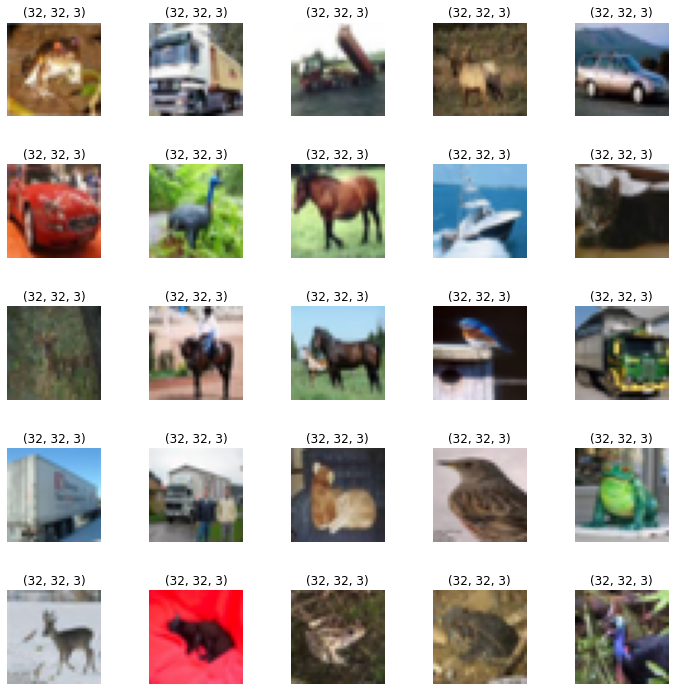

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(training_raw)
fig, ax = plt.subplots(5,5,figsize=(10,10))
fig.tight_layout()
ax = ax.flatten()
for i,(img, label) in enumerate(train_ds):
    ax[i].imshow((img))
    ax[i].set_title((img.numpy().shape))
    ax[i].axis("off")
    if i == 24:
        break

## Global settings
We will train this Network in phases inspired from this [paper](https://arxiv.org/pdf/1801.02929.pdf). The paper also introduces sample pairing which we will explain later. For now it's enough to know, that it helps preventing overfitting of the training data and is a method of data augmentation. Although the idea and the model structure is from the paper, we changed the augmentation and training part a bit which lead to better results then the writers were able to achive. In addition, we are not entirely sure if there are further requirements than the test accuracy for the global rank for cifar10. If not, this Network belongs to the [top30](https://paperswithcode.com/sota/image-classification-on-cifar-10) worldwide, regarding test accuracy on cifar10.


In [ ]:
# these parameters are used to create a list of indices to later select 
# the right manipulated dataset for training in each epoch
NO_PAIRING = 0
WITH_PAIRING = 1
SEQUENTIAL_PARING = lambda pairing, no_pairing: [WITH_PAIRING]*pairing + [NO_PAIRING]*no_pairing

In [ ]:
## HYPERPARAMETERS
# Data
BATCH_SIZE = 64
SHUFFLE_BUFFER = 50000 # the large shuffle buffer will be very important later!
CACHE_PATH = "/content/drive/MyDrive/cache/"
SAVE_PATH = "/content/drive/MyDrive/Models/cifar10_Model_"
SAVING_THRESHOLD = 0.96 # minimum accuracy before saving the model

# Training
# initialize the Training phases sequentially
PHASECONTROLLER = [NO_PAIRING]*2 + [WITH_PAIRING]*8 + SEQUENTIAL_PARING(pairing=8, no_pairing=2)*5 + [NO_PAIRING]*5
EPOCHS = len(PHASECONTROLLER)
LEARNING_RATE = 0.00005

# loss
LOSS_FUNCTION = tf.keras.losses.categorical_crossentropy
# optimizer
OPTIMIZER = tf.keras.optimizers.Adam(LEARNING_RATE)

## Datapipeline and Data Augmentation

In [ ]:
if not os.path.exists(CACHE_PATH):
    os.makedirs(CACHE_PATH[:-1])

In [ ]:
def blend(img1, img2, blending_factor=0.5, prob=0.8):
    '''
    IN:
        img1: image with shape (h,w,c)
        img2: imgae with shape (h,w,c)
        blending_factor: float in range [0:1], intensity of img1 in the new img
        prob: float in range[0:1], probability of success
    OUT:
        img: result of blending img1 and img2 by blending_factor
    '''
    if tf.random.uniform([1]) > prob or blending_factor > 1 or blending_factor < 0:
        return img1
    
    return (img1*blending_factor) + img2*(1-blending_factor)

In [ ]:
def data_augmentation(dataset, horizontal_flip=True, sample_pairing=True):
    '''
    Possible Augmentations:
        horizontal_flip: randomly flips imgs of the dataset horizontally.
        sample_pairing: blends two random img together. Twist: there is a 25% chance to skip the whole augmentation.
    '''
    AUTOTUNE = tf.data.experimental.AUTOTUNE

    if horizontal_flip:
        dataset = dataset.map(lambda img, label: (tf.image.random_flip_left_right(img), label),
                              num_parallel_calls=AUTOTUNE)

    if sample_pairing and tf.random.uniform([1]) < 0.75:
        # first split the dataset into its img and label
        ds_images = dataset.map(lambda img, label: img)
        ds_labels = dataset.map(lambda img, label: label)

        # shuffle the img dataset and store it seperately. For better results the buffersize should be big
        # enough such that also pictures of different classes will be paired later.
        shuffled_ds = ds_images.shuffle(SHUFFLE_BUFFER)

        # zip all back together
        merged_ds = shuffled_ds.zip((ds_images, shuffled_ds, ds_labels))

        # blend two random imgs (pixlewise) with equal(50%:50%) strenght together and use the label of the first one
        dataset = merged_ds.map(lambda img1, img2, label1: (blend(img1, img2, blending_factor=0.5, prob=0), label1),
                                num_parallel_calls=AUTOTUNE)
        
    return dataset
    

In [1]:
def build_pipeline(data, batchsize, shuffle_buffer, horizontal_flip=False, sample_pairing=False):
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.map(lambda img, label: (2*(img/255)-1, # normalize the color values between [-1:1]
                                    tf.reshape(tf.one_hot(label, 10), shape=(-1,)))) # one hot the labels
    
    # cache the preprocessing for better performance
    ds = ds.cache(CACHE_PATH)

    # if one of the data augmentations is choosen, apply them.
    if horizontal_flip or sample_pairing:
        ds = data_augmentation(ds, horizontal_flip, sample_pairing)

    ds = ds.shuffle(buffer_size=shuffle_buffer)
    ds = ds.batch(batchsize)

    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    return ds

## Creating Model

In [ ]:
class Model(Model):
    def __init__(self):

        super(Model, self).__init__()
        # create a list of all layers to iterate over all later.
        self.layer_list = [
                           
        #first conv layer 
        layers.Conv2D(filters=64,kernel_size=3, kernel_regularizer = tf.keras.regularizers.l2(l2=0.01),input_shape=(BATCH_SIZE, 32, 32, 3), padding="same"),
        
        #normalize batch
        layers.BatchNormalization(),
        layers.Activation('relu'),
        
        #second conv layer 
        layers.Conv2D(filters=96,kernel_size=3,kernel_regularizer = tf.keras.regularizers.l2(l2=0.01),padding="same"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2,2)),

        # third conv layer 
        layers.Conv2D(filters=96,kernel_size=3,kernel_regularizer = tf.keras.regularizers.l2(l2=0.01),padding="same"),
        layers.BatchNormalization(),
        layers.Activation('relu'),

        # fourth conv layer 
        layers.Conv2D(filters=128,kernel_size=3,kernel_regularizer = tf.keras.regularizers.l2(l2=0.01),padding="same"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        
        # fifth conv layer 
        layers.Conv2D(filters=128,kernel_size=3,kernel_regularizer = tf.keras.regularizers.l2(l2=0.01),padding="same"),
        layers.BatchNormalization(),
        layers.Activation('relu'),

        # sixth conv layer
        layers.Conv2D(filters=192,kernel_size=3,kernel_regularizer = tf.keras.regularizers.l2(l2=0.01),padding="same"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Flatten(),

        # final layers
        layers.Dropout(0.4),
        layers.Dense(units=512),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        #output layer 
        layers.Dense(10,activation=tf.keras.activations.softmax)
        ]
    
    @tf.function
    def call(self, x, training = True):
        #Define the forward step
        #iterate through a previously defined list with layers and return the end result
        for layer in self.layer_list:
          x = layer(x, training = training)
        
        return x

## Training Methods

In [ ]:
def forward_step(model, img, label ,loss_func, optimizer, training=True):
    with tf.GradientTape() as tape:
        prediction = model(img, training)
        loss = loss_func(label, prediction) + tf.reduce_sum(model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # calc accuracy of the batch
    sample_test_accuracy = np.argmax(label, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)  

    return np.mean(loss), sample_test_accuracy

def test(model, test_data, loss_function):
    # test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (data, target) in test_data:
        prediction = model(data, False)
        ## Calc Loss and its partial mean
        sample_test_loss = loss_function(target, prediction)
        test_loss_aggregator.append(np.mean(sample_test_loss.numpy()))
        
        ## Calc Accuracy and its partial mean
        sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_accuracy_aggregator.append(sample_test_accuracy)

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

# thanks to Cornelius who shared this function which I adjusted a bit
def estimateTime(epoch, time_passed, number_of_epochs):
    """
    estimates the time it will take until the network is done with training.
    """
    epoch += 1
    time_per_epoch = time_passed / epoch
    number_of_epochs_left = number_of_epochs - epoch
    time_sec_remaining = number_of_epochs_left * time_per_epoch
    time_remain = str(datetime.timedelta(seconds=time_sec_remaining))
    return time_remain


def save_best_weights(accuracy, best_so_far):
    '''saves the best model if acc > preset threshold and if it is the best one so far'''
    if accuracy > SAVING_THRESHOLD and best_so_far:
        model.save(SAVE_PATH + str(int(accuracy*100)))
        return True
    return False

## Training
Idea of sample pairing:
The goal of sample pairing is to give the network a hard time classifying while training, since it will see imgs of potentially different classes blended equally into each other but having only the label of the first img. Like this the Network is not really abel to classify correct while sample pairing is enabled. The idea is that the network is forced to  concentrate more on the features which seperates the imgs and not those which they might have in common. The paper used some more augmentation strategies like random cropping and had less paired imgs for each pipeline. They also used less original pictures of the dataset and rather created more by randomly pairing which did not. I only used each picture with its corresponding label once. Originally they had probability involved when pairing, such that not all imgs where paired in a Pairing Phase. (If I remember correctly) I tried that but it turned out that an all or nothing priciple lead to better results. By randomly introducing a big chunk of noise (or rather no noise) made the training instabel in means of strongly jumping test accuracy values. This might sound negative but imagine it as rolling down the error surface hill and randomly jumping back up to maybe take an alternative way down. Like this we were abel get consistent 95%+ accuracies each training. Choosing when to end was hard because of this jumping behaviour. Thats why used some kind of maximum search for weight assignments, and saved the best results.

- First we initialize our data pipelines
    - We will have two training data pipelines, one with only horizontal flip and one with horizontal flip and sample pairing.
    - Test dataset will be without any augmentation.
- We will train in Phases as specified above. The idea is to start of w/ out pairing, then activate pairing for some time. Later we will alternate between w/ and w/ out and in the end we will use 5 Epochs w/ out pairing for fine tuning. Note well that even if the Phase controller says sample pairing is activated, there is a 25% chance of not applying it. 

In [ ]:
training_ds = [None, None]
training_ds[0] = build_pipeline(training_raw, BATCH_SIZE, SHUFFLE_BUFFER, horizontal_flip=True)
training_ds[1] = build_pipeline(training_raw, BATCH_SIZE, SHUFFLE_BUFFER, horizontal_flip=True, sample_pairing=True)
test_ds = build_pipeline(test_raw, BATCH_SIZE, SHUFFLE_BUFFER)

In [ ]:
tf.keras.backend.clear_session()

startTime = time.time()
print(f"Initialize, {datetime.timedelta(seconds=startTime)}")

# Initialize NN
model = Model()

# lists for vizualisation
training_losses = []
training_accuracies = []
test_losses = []
test_accuracies = []

# let's test our Model how it performes on the test dataset before learning
test_loss, test_accuracy = test(model, test_ds, LOSS_FUNCTION)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# check how our Model performs on training dataset before learning
training_loss, training_accuracy = test(model, training_ds[0], LOSS_FUNCTION)
training_losses.append(training_loss)
training_accuracies.append(training_accuracy)

print(f"Start Training for {EPOCHS} Epochs", f"Training Loss: {np.round(float(training_loss), 3)}, Training Accuracy: {np.round(training_accuracy*100, 3)}%, Test Loss: {np.round(float(test_loss),3)}, Test Accuracy: {np.round(test_accuracy*100, 3)}%", sep="\n")

startTime = time.time()
# We train for before specified epochs.
for epoch in range(EPOCHS):
    if epoch % 5 == 0:
        print("-"*20)
    print('Epoch: __ ', (epoch + 1))#, ", Pairing = " + str(bool(PHASECONTROLLER[epoch])))

    # perform a training step with each entry of our data pipeline and record loss and accuracy
    t_acc_accumulator = []
    for (data, label) in training_ds[PHASECONTROLLER[epoch]]:
        training_loss, training_accuracy = forward_step(model, data, label, LOSS_FUNCTION, OPTIMIZER)
        t_acc_accumulator.append(training_accuracy)

    # save loss and accuracy
    training_losses.append(training_loss)
    training_accuracies.append(np.mean(t_acc_accumulator))

    # check how our Model performs after one learning epoch on our test dataset and record Loss and Acc. as well
    test_loss, test_accuracy = test(model, test_ds, LOSS_FUNCTION)
    test_losses.append(test_loss)
    
    # check if we have a new best score and save the model if it is good enough
    if save_best_weights(test_accuracy, np.max(test_accuracies) < test_accuracy):
        print(f"CONGRATS, NEW BEST ACCURACY OF {np.round(test_accuracy, 3)}. MODEL WAS SAVED!")
    
    test_accuracies.append(test_accuracy)
    print(f"Training Loss: {np.round(float(training_loss), 3)}, Training Accuracy: {np.round(training_accuracies[epoch]*100, 3)}%, Test Loss: {np.round(float(test_loss), 3)}, Test Accuracy: {np.round(test_accuracy*100, 3)}%, Finish in: {str(estimateTime(epoch, time.time() - startTime, EPOCHS))[:7]}")

Initialize, 18598 days, 0:58:32.654804
Start Training for 65 Epochs
Training Loss: 2.303, Training Accuracy: 9.524%, Test Loss: 2.303, Test Accuracy: 9.355%
--------------------
Epoch: __  1
Training Loss: 7.198, Training Accuracy: 9.524%, Test Loss: 2.541, Test Accuracy: 9.813%, Finish in: 0:06:49
Epoch: __  2
Training Loss: 7.291, Training Accuracy: 22.064%, Test Loss: 2.484, Test Accuracy: 15.884%, Finish in: 0:06:22
Epoch: __  3
Training Loss: 6.964, Training Accuracy: 33.748%, Test Loss: 1.75, Test Accuracy: 36.734%, Finish in: 0:06:35
Epoch: __  4
Training Loss: 6.882, Training Accuracy: 39.67%, Test Loss: 1.407, Test Accuracy: 50.518%, Finish in: 0:06:38
Epoch: __  5
Training Loss: 6.612, Training Accuracy: 43.392%, Test Loss: 1.362, Test Accuracy: 52.906%, Finish in: 0:06:37
--------------------
Epoch: __  6
Training Loss: 6.815, Training Accuracy: 46.069%, Test Loss: 1.276, Test Accuracy: 55.802%, Finish in: 0:06:34
Epoch: __  7
Training Loss: 6.469, Training Accuracy: 48.01%,

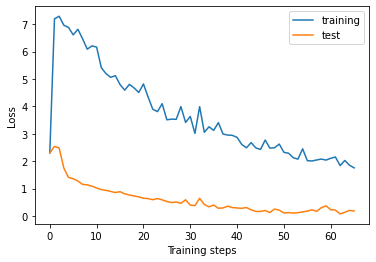

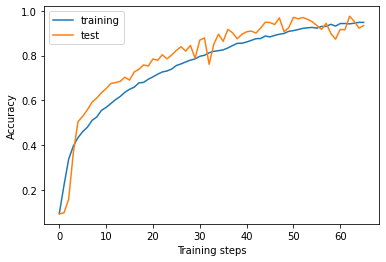

Max Accuracy: 97.532%


In [ ]:
# taken from Tensorflow_Intro.ipynb

# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(training_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(training_accuracies)
line2, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.legend((line1,line2),("training", "test"))
plt.show()
print(f"Max Accuracy: {np.round(np.max(test_accuracies)*100, 3)}%")

## Load our Best Model from training and make some nice cakes

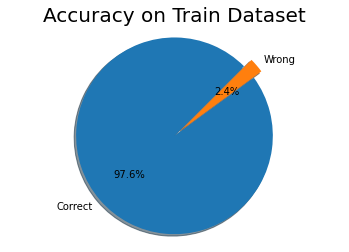

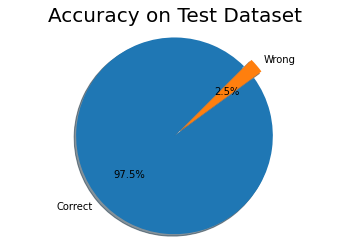

In [ ]:
# load and compile our best model
model = tf.keras.models.load_model(SAVE_PATH+str(97))
model.compile()

# test their performance once again
_, test_acc = test(model, test_ds, LOSS_FUNCTION)
_, train_acc = test(model, training_ds[0], LOSS_FUNCTION)

labels = 'Correct', 'Wrong'
explode = (0, 0.1)

# cook some cakes
fig1, ax1 = plt.subplots()
ax1.pie([train_acc, 1-train_acc], explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=45)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Accuracy on Train Dataset", fontdict={"fontsize":20})
plt.show()

fig1, ax1 = plt.subplots()
ax1.pie([test_acc, 1-test_acc], explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=45)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Accuracy on Test Dataset", fontdict={"fontsize":20})
plt.show()